In [ ]:
# default_exp dataloaders

In [ ]:
# hide
# missing
!git clone https://github.com/marcomatteo/steel_segmentation.git

In [ ]:
# hide
# missing
!pip install -e steel_segmentation

# Dataloaders

> Loading data for training DL models.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/marcomatteo/steel_segmentation/blob/master/dev_nbs/04_dataloaders.ipynb)

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from steel_segmentation.metadata import *
from steel_segmentation.masks import *
from steel_segmentation.datasets import *

from fastcore.test import *
from fastai.vision.all import *
from PIL import Image
from collections import defaultdict
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import os
import cv2

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
import albumentations as alb

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()

## Fast.ai DataBlock API

In this module you can have functions for a classification and a segmentation problem. 

With the `DataBlock` API of *fast.ai* we can build in a easy way to training (with `train` attribute) and valid (with `valid` attribute) the datasets inside a `Datasets` fastai class.

With a `DataLoaders` we can load the data into a GPU applying the transforms. It calls the Pytorch `DataLoader` on each subset of `Datasets`.

The list of tfms applied is:

- *after_item*: applied on each item after grabbing it inside the dataset.

- *before_batch*: applied on the list of items before they are collated.

- *after_batch*: applied on the batch as a whole after its construction.

### Multi-class image segmentation

In [ ]:
#hide
size = None

In [ ]:
b_tfms = aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1) + [Normalize.from_stats(*imagenet_stats)]

In [ ]:
b_tfms

[Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]]), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]]), 'axes': (0, 2, 3)}:
 encodes: (TensorImage,object) -> encodes
 decodes: (TensorImage,object) -> decodes]

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock()),
    get_x=ColReader(0, pref=train_path),
    get_y=ColReader(1, label_delim=' '),
    splitter=RandomSplitter(valid_pct=0.2),
    batch_tfms=b_tfms)

Now we can check that all is alright passing a `source` into the `dblock` and the API returns all the process explained.

Setting-up type transforms pipelines
0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
    start

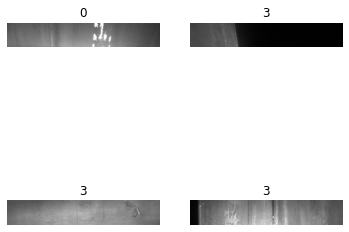

In [ ]:
dblock.summary(train_multi, show_batch=True)

To create `DataLoaders` the batch size is needed.

In [ ]:
dloader = dblock.dataloaders(train_multi, bs=8, verbose=True, device='cpu')
type(dloader)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: ColReader -- {'cols': 0, 'pref': Path('../data/train_images'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 1, 'pref': '', 'suff': '', 'label_delim': ' '} -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': (256, 1600)

fastai.data.core.DataLoaders

An example of pipeline:

In [ ]:
f = dloader.after_item
items = [f(dloader.create_item(i)) for i in range(4)]
items[0][0].shape, items[0][1]

((3, 256, 1600), TensorMultiCategory([0., 0., 0., 0., 1.]))

In [ ]:
batch = dloader.do_batch([item for item in items]) # apply before_batch
batch[0].shape, batch[1]

((4, 3, 256, 1600),
 TensorMultiCategory([[0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0.]]))

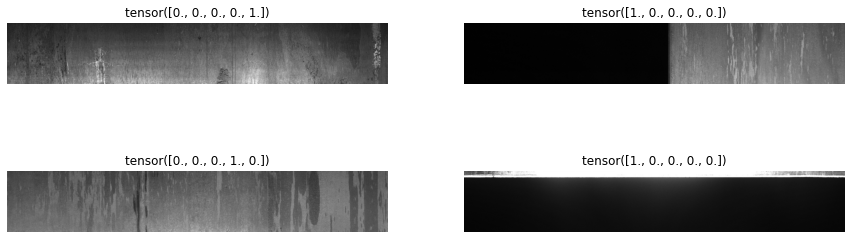

In [ ]:
show_image_batch(batch, items=4, cols=2, figsize=(15,5))

In [ ]:
batch[0].device, dloader.device

(device(type='cpu'), 'cpu')

In [ ]:
batch_tfms = dloader.after_batch(batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


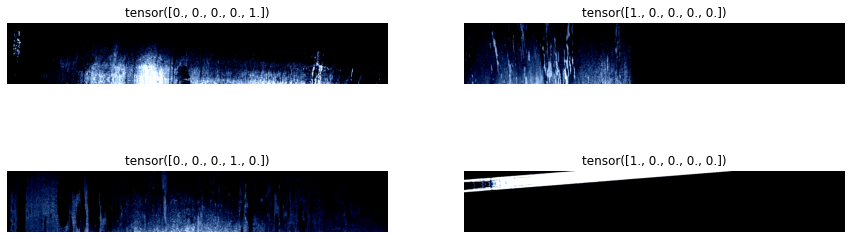

In [ ]:
show_image_batch(batch_tfms, items=4, cols=2, figsize=(15,5))

In [ ]:
# export
def get_classification_dls(bs, with_tfms: bool = True, size=None, seed=42):
    """
    Dataloaders from train DataFrame
    """
    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_tfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)

    dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock()),
        get_x=ColReader(0, pref=train_path),
        get_y=ColReader(1, label_delim=' '),
        splitter=RandomSplitter(valid_pct=0.2, seed=seed),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_multi, bs=bs)

In [ ]:
bs = 4
dls = get_classification_dls(bs)

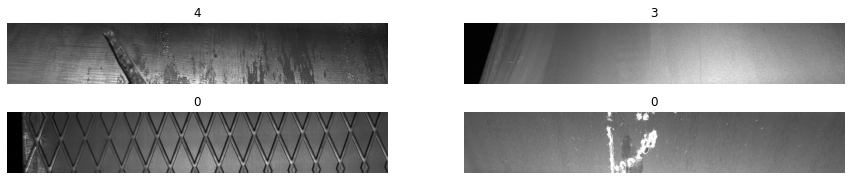

In [ ]:
dls.train.show_batch(figsize=(15, 3))

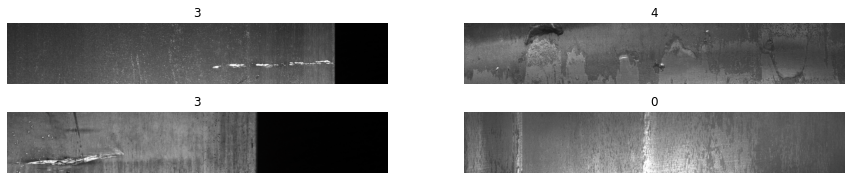

In [ ]:
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
x, y = dls.train.one_batch()
x.shape, y.shape

(torch.Size([4, 3, 256, 1600]), torch.Size([4, 5]))

### Segmentation

To get a `DataLoaders` object for training segmentation FastAI models, we need to: 
- load the training images
- load the corrisponding labels (saved in `labels_dir` by the `preprocessing` module with the `create_mask` function)
- pair the images with labels with a `Dataset`
- split the dataset into training and validation and pair them with a `Datasets` object.
- for each dataset, create a `DataLoader` with a batch size and pair them with a `DataLoaders` object.

In [ ]:
# export
classes = [0, 1, 2, 3, 4]

In [ ]:
#hide
size = (256,1600)

In [ ]:
btfms = aug_transforms(
            size=size, 
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)
btfms

[Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

In [ ]:
def get_x(s):
    img_name = s["ImageId"]
    return train_path / str(img_name)

def get_y(s):
    img_name = s["ImageId"].split(".")[0] + "_P.png"
    return labels_path / img_name

dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=classes)),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    batch_tfms=btfms)

Setting-up type transforms pipelines
0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      ClassId
ImageId          0fac62a3e.jpg
ClassId_multi                0
Name: 761, dtype: object
    applying get_x gives
      ../data/train_images/0fac62a3e.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1600x256
  Pipeline: get_y -> PILBase.create
    starting from
      ClassId
ImageId  

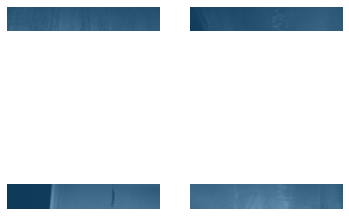

In [ ]:
dblock.summary(train_multi, show_batch=True)

In [ ]:
dloader = dblock.dataloaders(train_multi, verbose=True, bs=4)

0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3
...                ...           ...
12563    fff0295e1.jpg             0
12564    fff02e9c5.jpg             3
12565    fffe98443.jpg             3
12566    ffff4eaa8.jpg             3
12567    ffffd67df.jpg             3

[12568 rows x 2 columns]
Found 12568 items
2 datasets of sizes 10055,2513
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': (256, 1600), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.1, 'p': 1.0, 'draw': None, 'batch': False}


In [ ]:
type(dloader)

fastai.data.core.DataLoaders

In [ ]:
dloader.train_ds[0]

(PILImage mode=RGB size=1600x256, PILMask mode=L size=1600x256)

In [ ]:
xb, yb = next(iter(dloader.train))
xb.shape, yb.shape

An example of pipeline:

In [ ]:
# missing
elems = [13, 17, 25]
n = len(elems)
figszs = (40,20)
imgszs = (25,5)

In [ ]:
# missing
f = dloader.after_item
items = [f(dloader.create_item(i)) for i in elems]
items[0][0].shape, items[0][1].shape, items[0][0].max(), items[0][0].min()

((3, 256, 1600),
 (256, 1600),
 TensorImage(255, dtype=torch.uint8),
 TensorImage(4, dtype=torch.uint8))

In [ ]:
# missing
img_batch, mask_batch = dloader.do_batch([item for item in items])
img_batch.shape, mask_batch.shape

((3, 3, 256, 1600), (3, 256, 1600))

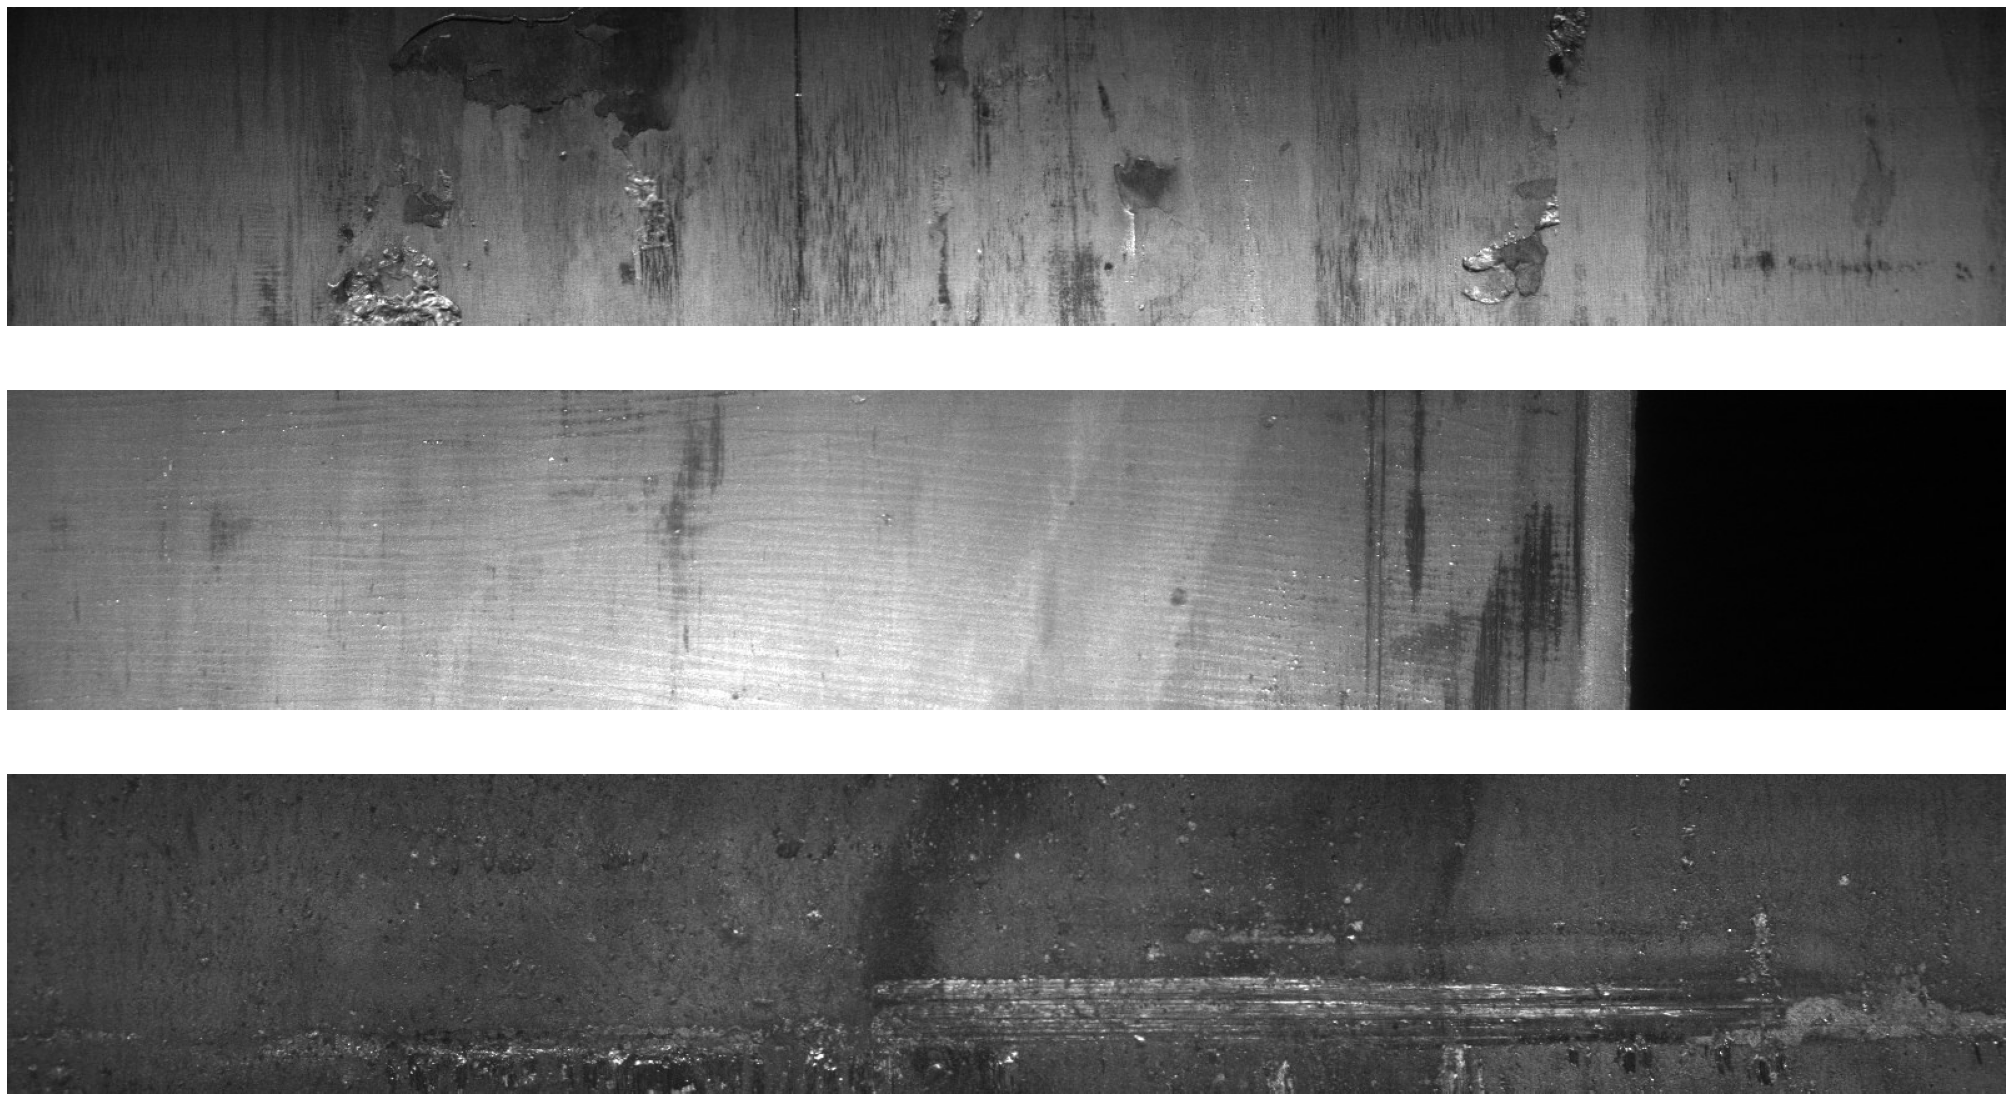

In [ ]:
# missing
fig, axs = plt.subplots(n, 1, figsize=figszs)
for i in range(len(axs)):
    show_image(img_batch[i], ax=axs[i], figsize=imgszs)

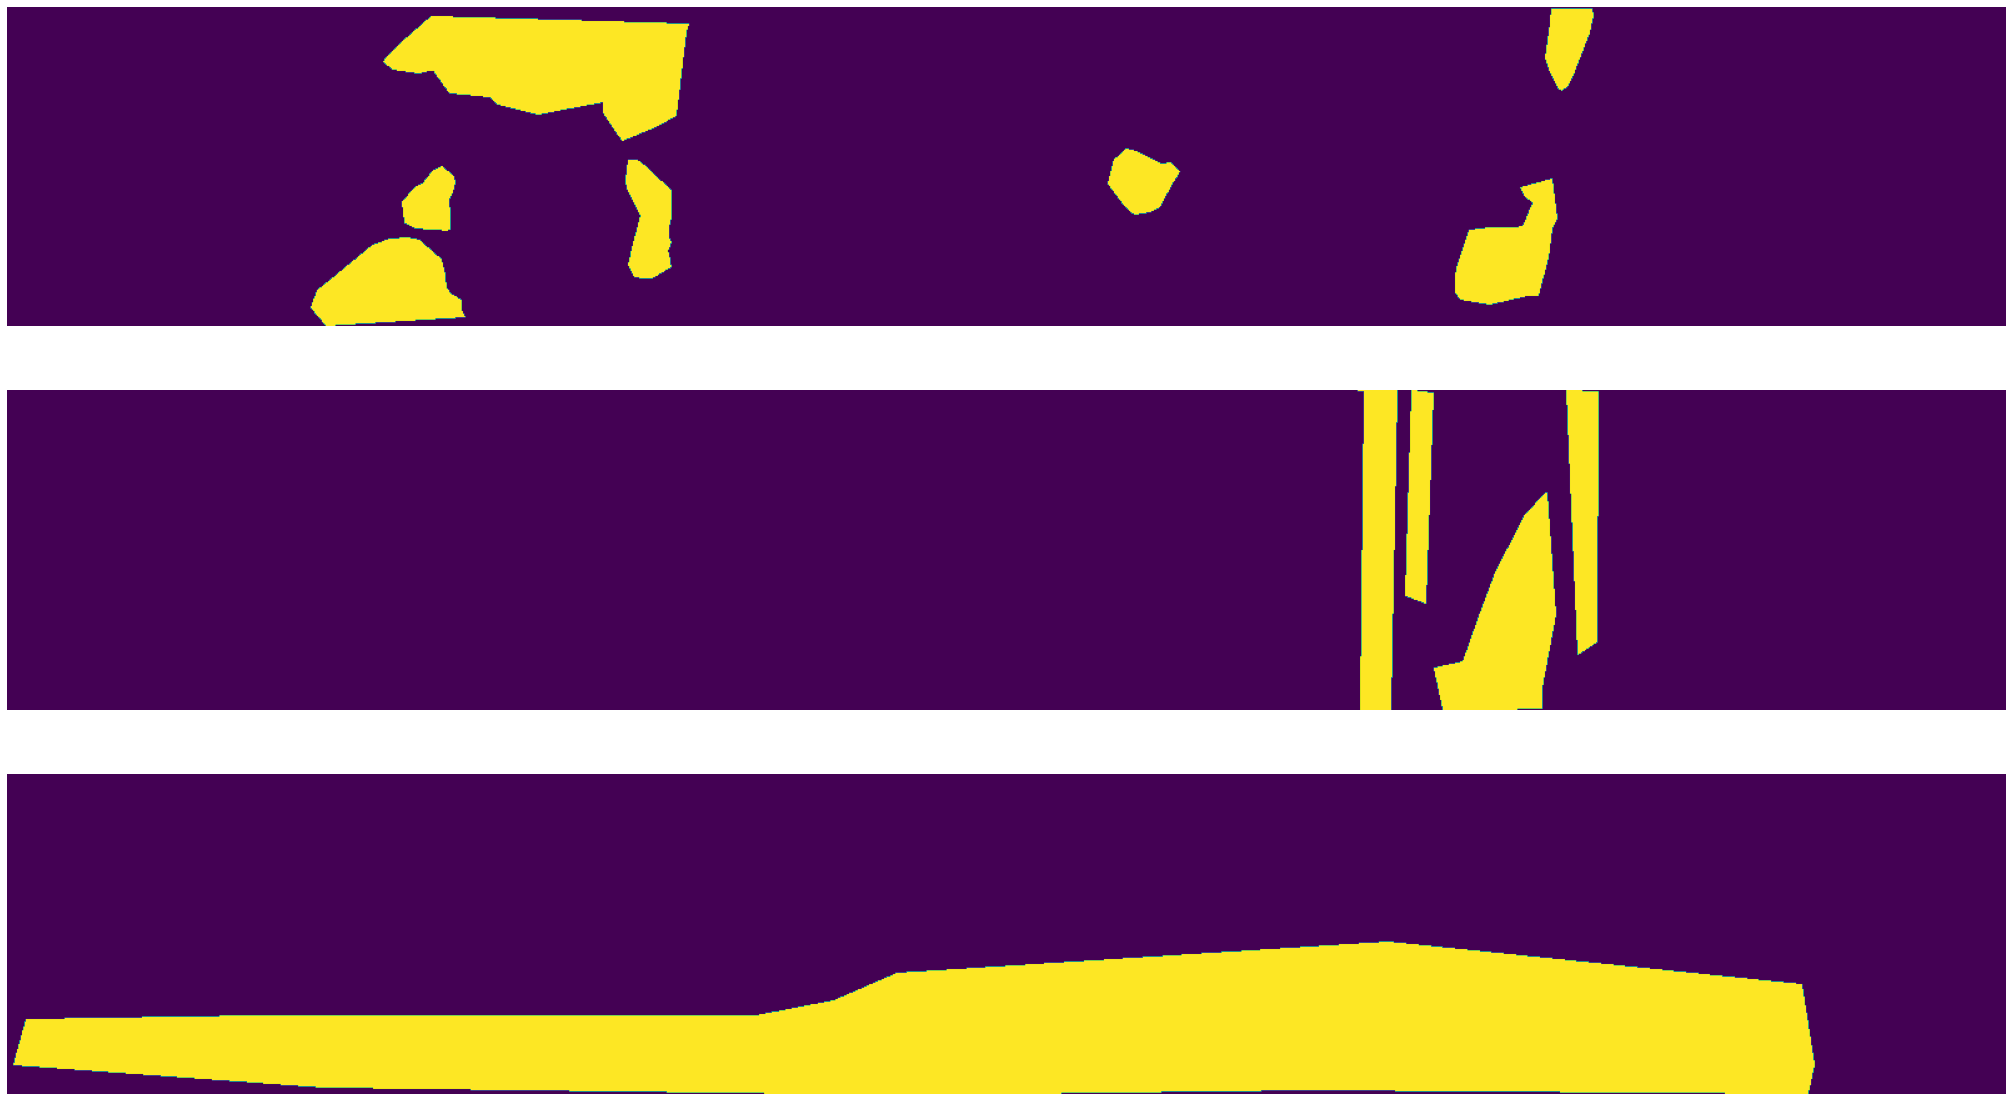

In [ ]:
# missing
fig, axs = plt.subplots(n, 1, figsize=figszs)
for i in range(len(axs)):
    show_image(mask_batch[i], ax=axs[i], figsize=imgszs)

In [ ]:
# missing
img_tfbatch, mask_tfbatch = dloader.after_batch((img_batch, mask_batch))
img_tfbatch.shape, mask_tfbatch.shape 

((3, 3, 256, 1600), (3, 256, 1600))

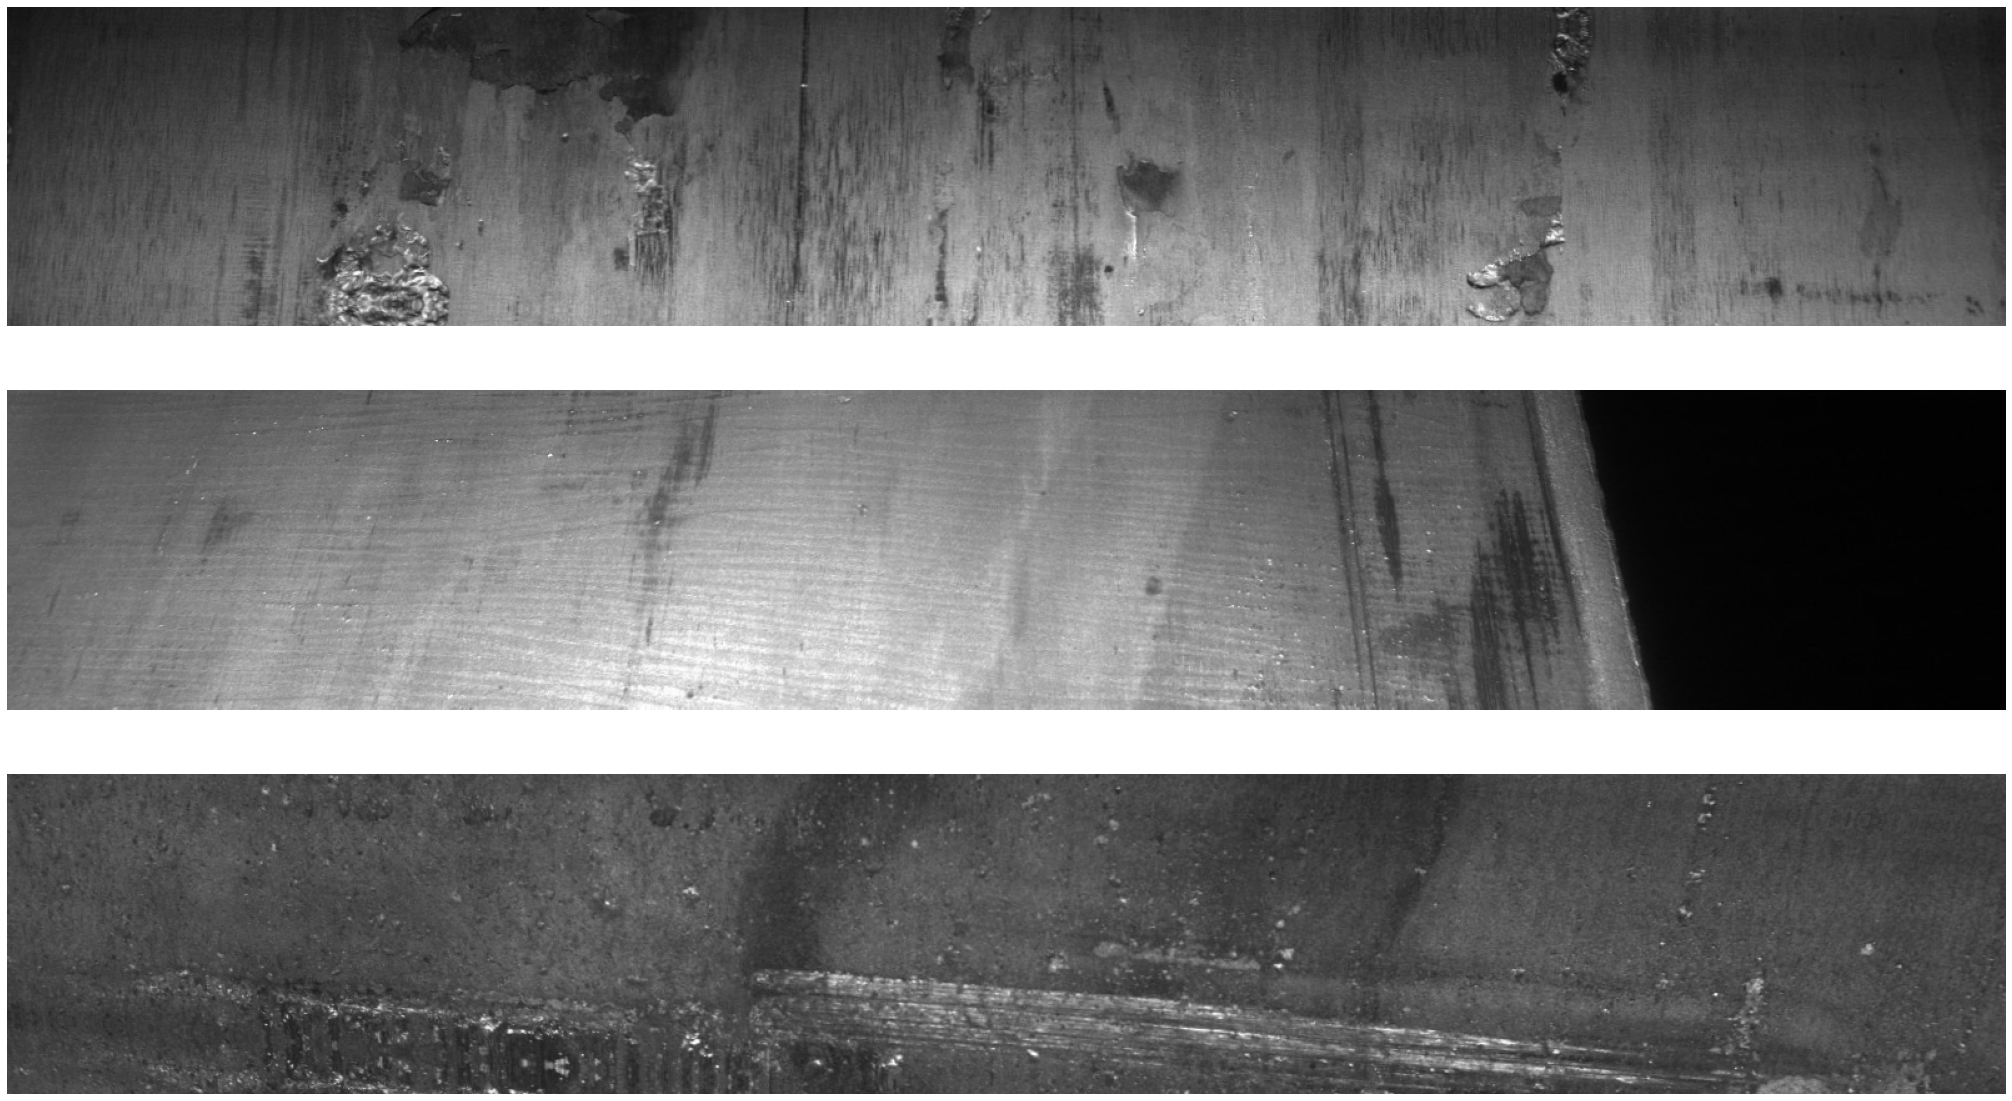

In [ ]:
# missing
fig, axs = plt.subplots(n, 1, figsize=figszs)
for i in range(len(axs)):
    show_image(img_tfbatch[i], ax=axs[i], figsize=imgszs)

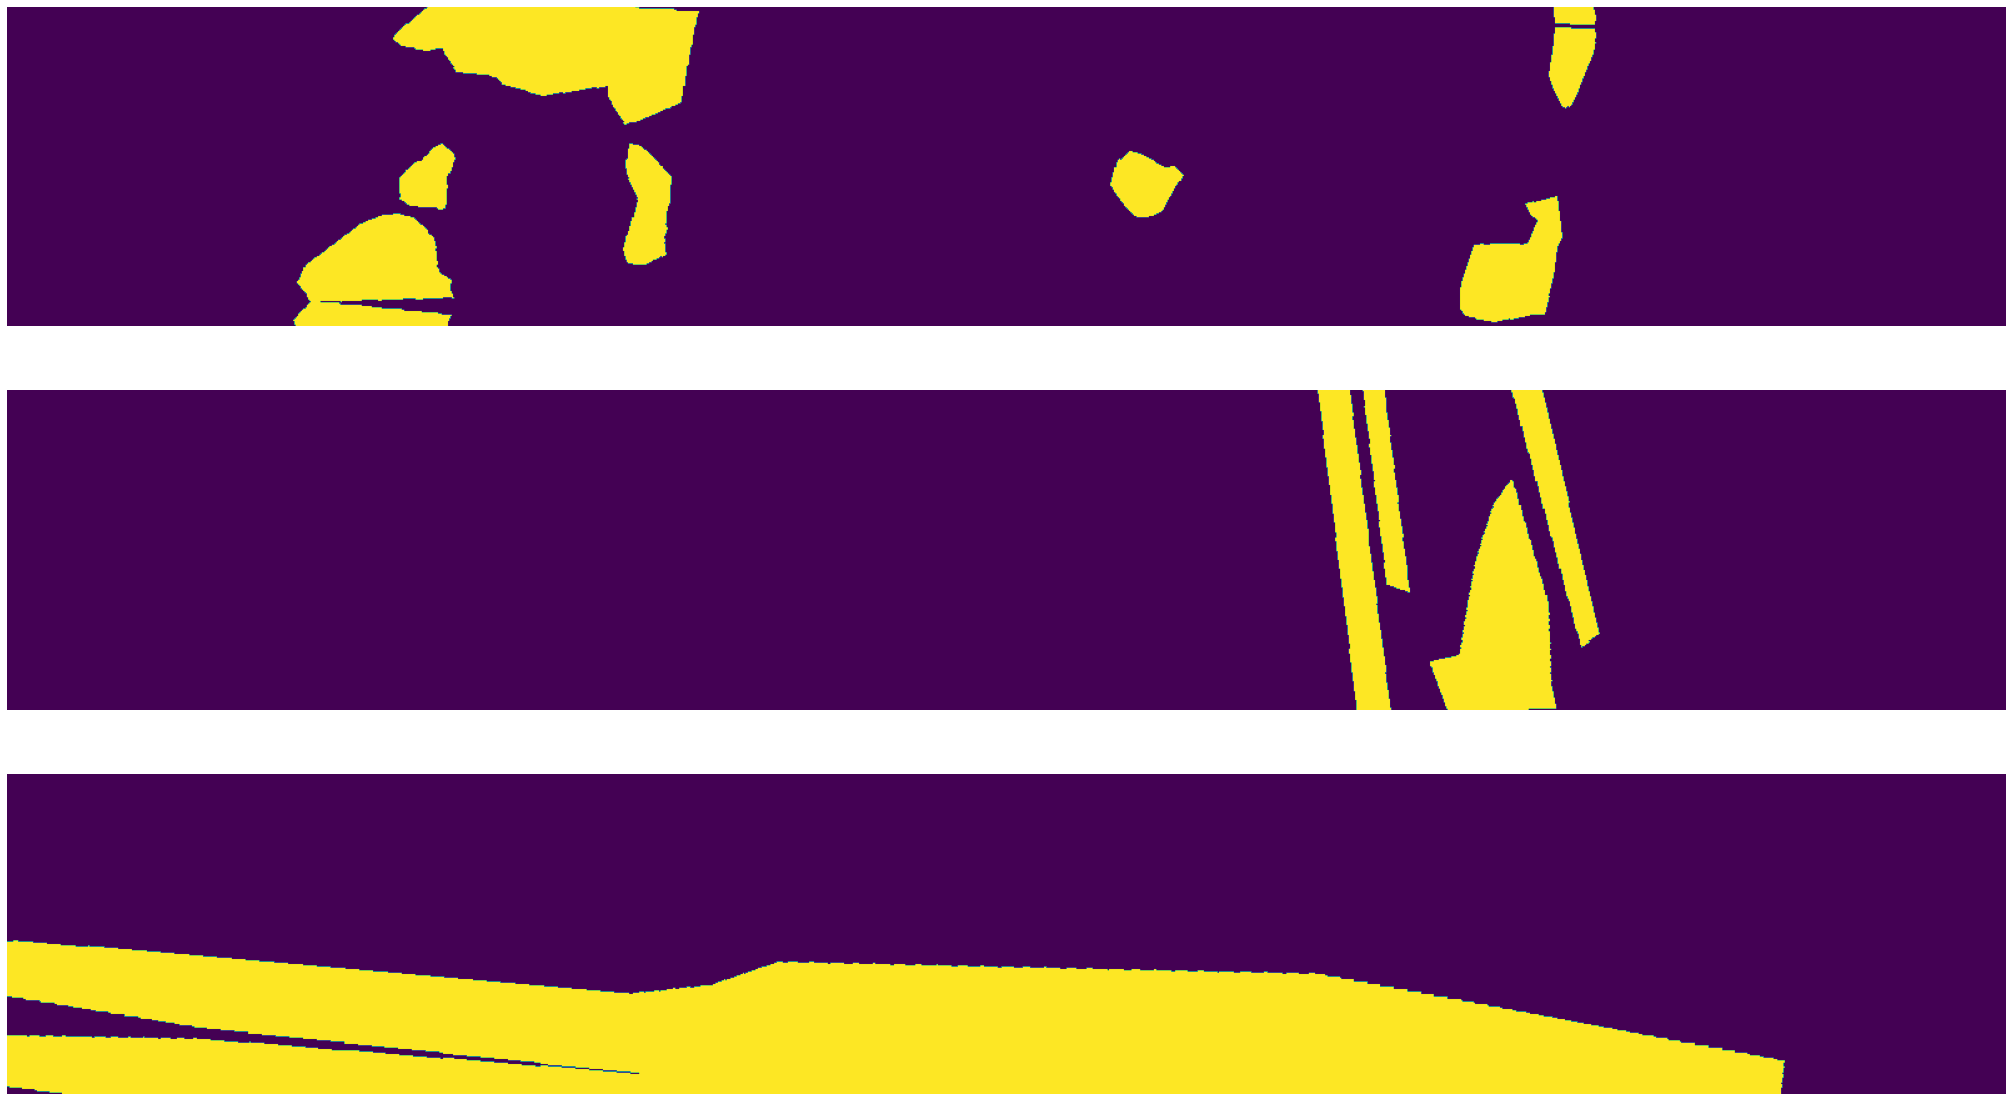

In [ ]:
# missing
fig, axs = plt.subplots(n, 1, figsize=figszs)
for i in range(len(axs)):
    show_image(mask_tfbatch[i], ax=axs[i], figsize=imgszs)

In [ ]:
# missing
for img in img_tfbatch:
    print(img.min(), img.max())

tensor(0.0426) tensor(1.0000)
tensor(0.0004) tensor(1.0000)
tensor(0.1151) tensor(1.0000)


In [ ]:
# missing
for mask in mask_batch:
    print(mask.min(), mask.max())

tensor(0, dtype=torch.uint8) tensor(4, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(3, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(3, dtype=torch.uint8)


The `get_segmentation_dls` will load from the folder all the images while the `get_segmentation_dls_from_df` loads the images from a custom `DataFrame` to train on a different subsample.

In [ ]:
#export
def get_segmentation_dls(bs, size, with_btfms=True, seed=42):
    """Dataloaders from `train_path` folder"""

    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_btfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)

    def get_labels_from_img(p):
        return labels_path/f'{p.stem}_P.png'

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_items=get_image_files,
        get_y=get_labels_from_img,
        splitter=RandomSplitter(valid_pct=0.2, seed=seed),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_path, bs=bs)

In [ ]:
# export
def get_segmentation_dls_from_df(train_df, bs, size, with_btfms=True, seed=42):
    """Dataloaders from `train` DataFrame"""
    def get_x(df):
        img_name = df["ImageId"]
        return train_path / str(img_name)

    def get_y(df):
        img_name = df["ImageId"].split(".")[0] + "_P.png"
        return labels_path / img_name

    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_btfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=.1,
            max_rotate=5.,
            max_lighting=0.1)

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_x=get_x,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2, seed=seed),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_df, bs=bs)

In [ ]:
# missing
bs = 4
szs = (128, 800)
dls = get_segmentation_dls_from_df(train_multi, bs, szs)

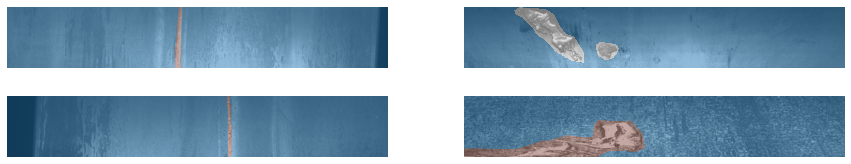

In [ ]:
# missing
dls.train.show_batch(figsize=(15, 3))

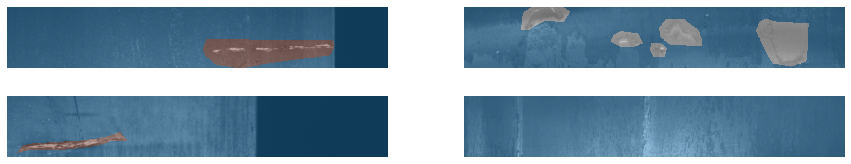

In [ ]:
# missing
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
# missing
x, y = dls.train.one_batch()
x.shape, y.shape

((4, 3, 128, 800), (4, 128, 800))

In [ ]:
# missing
[torch.unique(y[i]) for i in range(bs)]

[TensorMask([0, 3]), TensorMask([0, 4]), TensorMask([0, 3]), TensorMask([0])]

## Pure Pytorch

The fast.ai Datablock API is very useful, we can load the images and apply transforms very quickly.
On the other side it can be a limit when experimenting with other models or with custom transformations and requires a deeper knoledge of the high-level API. 

Here some functions and classes from [this kernel](https://www.kaggle.com/rishabhiitbhu/unet-starter-kernel-pytorch-lb-0-88) for pure Pytorch `Dataset` and `DataLoader`.

In [ ]:
# export
def get_train_dls(
        phase,
        mean=None,
        std=None,
        batch_size=8,
        num_workers=4,
    ):
    '''Returns dataloader for the model training.'''
    df = train_pivot
    if (mean is None) or (std is None):
        mean, std = imagenet_stats
        
    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df["n"], random_state=69)
    
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, mean, std, phase)
    
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )

    return dataloader

In [ ]:
# missing
steel_dls = get_train_dls(phase='train')
test_eq(len(steel_dls), 1257)

In [ ]:
# missing
xb, yb = next(iter(steel_dls))
xb.shape, yb.shape

(torch.Size([8, 3, 256, 1600]), torch.Size([8, 4, 256, 1600]))

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_metadata.ipynb.
Converted 02_masks.ipynb.
Converted 03_datasets.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_metrics.ipynb.
Converted 06_loss.ipynb.
Converted 07_trainer.ipynb.
Converted 08_predict.ipynb.
Converted 09_visualize.ipynb.
Converted index.ipynb.
